# MVD 11. cvičení


## 1. část - Collaborative Filtering (item-item)

Vytvořte si matici podle příkladu v přednášce na item-item přístup na snímku 24. Využijte centered cosine similarity pro výpočet podobností stejně jako v přednášce a vyberte dva nejbližší sousedy. Ověřte, že je výsledek v přednášce správný a implementujte funkci tak, aby bylo možné jednoduše spočítat i libovolné další vyhodnocení. 

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install lazypredict
!{sys.executable} -m pip install matplotlib

In [66]:
import numpy as np
import pandas as pd
import torch
import sklearn
from lazypredict.Supervised import LazyClassifier
import matplotlib.pyplot as plt

In [12]:
data = np.array([
    [1,0,3,0,0,5,0,0,5,0,4,0],
    [0,0,5,4,0,0,4,0,0,2,1,3],
    [2,4,0,1,2,0,3,0,4,3,5,0],
    [0,2,4,0,5,0,0,4,0,0,2,0],
    [0,0,4,3,4,2,0,0,0,0,2,5],
    [1,0,3,0,3,0,0,2,0,0,4,0]
])

In [130]:
def center_vector(vector: np.array) -> np.array:
    """Centrování vektoru
    Vstupem je vektor a výstupem je centrováný vektor.
    """
    mask = (vector == 0)
    sum = np.sum(vector, axis=1) / np.count_nonzero(vector, axis=1)
    centered = np.where(mask, 0, vector - sum[:,np.newaxis])
    return centered

def similarity(a: np.array, b: np.array, centered = False) -> np.array:
    """
    Vstupem jsou dva vektory a výstupem je hodnota cosinove podobnosti.
    Přepínač: centered
        Vypočte se Pearson Correlation, tedy centrovanou podobnost
    """
    if centered:
        a = center_vector(a)
        b = center_vector(b)
    #return torch.nn.functional.cosine_similarity(a, b, dim=0)
    return sklearn.metrics.pairwise.cosine_similarity(a, b)
    #return np.dot(a, b.T)/(np.linalg.norm(a)*np.linalg.norm(b))

def collaborative_filtering(matrix : np.array, predict: tuple, k : int = 2):
    user, product = predict
    similarities = similarity(matrix[product,:].reshape(1,-1), matrix, centered = True).squeeze()
    indexes = np.argsort(similarities)[::-1][1:k+1]

    rating = np.sum(similarities[indexes] * matrix[indexes, user]) / np.sum(similarities[indexes])
    return rating


In [131]:
collaborative_filtering(matrix=data, predict=(4,0), k=2)

2.5864068669348175

## Bonus - Content-based Filtering

Stáhněte si Kaggle dataset [Spotify Recommendation system](https://www.kaggle.com/bricevergnou/spotify-recommendation). Z datasetu budete potřebovat:

- data.csv = příznaky k jednotlivým skladbám + příznak liked pro klasifikaci

Úkolem je:

1. Načíst data z csv.
2. Vytvořit train (90 %) a test (10 %) split pomocí knihovny [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
3. Vytvořit model logistické regrese (vlastní implementace / využití knihovny sklearn nebo jiné).
4. Vyhodnotit data na testovací sadě (např. metoda score u LogisticRegression).

**Skóre pro uznání úlohy musí být vyšší než 89 %.**

Dobrovolné: vytvořit graf predikovaných vs aktuálních hodnot

Získání bodu navíc: Využijte i další algoritmy pro binární klasifikaci.

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [13]:
# načtení dat z csv souboru
df = pd.read_csv("data/data.csv", sep=",")
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.4510,0.000734,0.1000,0.6280,95.968,304524,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.2060,0.000000,0.0912,0.5190,151.329,247178,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.9920,0.897000,0.1020,0.0382,75.296,286987,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.4310,0.000001,0.1230,0.5820,89.860,208920,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.1450,0.000000,0.0753,0.6470,155.117,179413,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.166,0.0551,9,-19.494,0,0.0520,0.9760,0.635000,0.1190,0.1430,176.616,206520,3,0
191,0.862,0.6240,3,-11.630,1,0.0565,0.0192,0.000153,0.0465,0.8820,124.896,254240,4,0
192,0.499,0.3510,9,-11.509,0,0.0448,0.9510,0.000099,0.1180,0.6160,90.664,235947,4,0
193,0.574,0.7290,10,-5.838,0,0.0965,0.0406,0.000004,0.1940,0.4130,110.547,190239,5,1


In [87]:
# filter out the feature variables
X = df.iloc[:,:-1]

# define the standard scaler to scale the values in the dataframe
scaler = StandardScaler()
X = scaler.fit_transform(X)

# filter out the label variable
y = df.iloc[:,-1]

# splitting the dataset according to the selected test_size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [88]:
# penalty{‘l1’, ‘l2’, ‘elasticnet’, None}, default=’l2’
# solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’

lr_clf = LogisticRegression()
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2', 'elasticnet', None],
              'solver': ['liblinear', 'saga']
            }

grid_search = GridSearchCV(lr_clf, param_grid_lr, cv=5)
grid_search.fit(X_train, y_train)

print('Best Parameters -', grid_search.best_params_)
print('Best Accuracy Score -', grid_search.best_score_)

Best Parameters - {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Accuracy Score - 0.9142857142857144


In [89]:
model = LogisticRegression().fit(X_train, y_train)
print("Score:", model.score(X_test, y_test))

Score: 0.85


In [90]:
print("Best paramteres:", grid_search.best_params_)
model = LogisticRegression(**grid_search.best_params_).fit(X_train, y_train)
print("Score:", model.score(X_test, y_test))

Best paramteres: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Score: 0.9


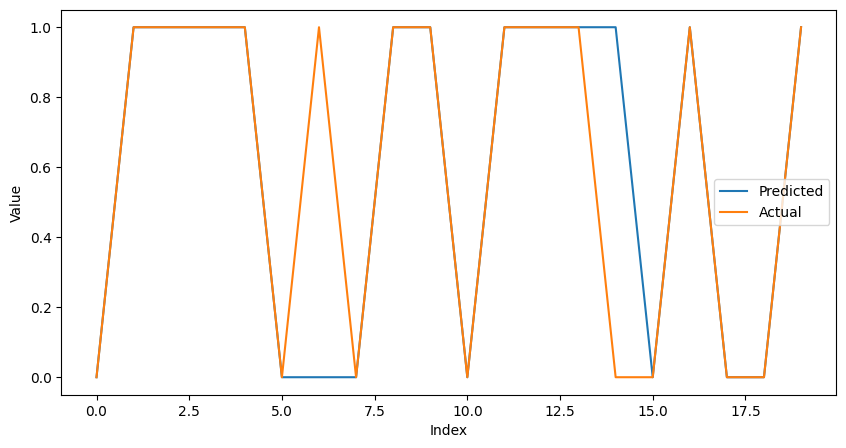

In [92]:
# plot test predictions vs actual values
plt.figure(figsize=(10,5))
plt.xlabel("Index")
plt.ylabel("Value")
plt.plot(model.predict(X_test), label="Predicted")
plt.plot(y_test.values, label="Actual")
plt.legend()
plt.show()


### Další algoritmy pro binární klasifikaci

In [64]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 29/29 [00:01<00:00, 16.64it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.95               0.96     0.96      0.95   
ExtraTreesClassifier               0.95               0.96     0.96      0.95   
LabelSpreading                     0.95               0.96     0.96      0.95   
LabelPropagation                   0.95               0.96     0.96      0.95   
BaggingClassifier                  0.90               0.92     0.92      0.90   
RandomForestClassifier             0.90               0.92     0.92      0.90   
NuSVC                              0.90               0.92     0.92      0.90   
SGDClassifier                      0.90               0.92     0.92      0.90   
SVC                                0.90               0.92     0.92      0.90   
XGBClassifier                      0.90               0.92     0.92      0.90   
BernoulliNB                 